## Приняте решения по результатам А/В теста

#### Анализ скидок для сервисов "Жилая недвижимость"
Команда занимается сервисами для владельцев жилой недвижимости и последний год продает клининговые услуги по модели подписки (на месяц и на год). Цены - 200 и 1000 руб. соответственно.\
Решили посмотреть, как скидки влияют на аудиторию. Поделили всех неплативших пользователей, которые заходили в период скидок, на группы А и В. Группе А не давали скидок, а группе В дали скидку 30% на любую из подписок.\
\
Тест проводили с 2019-08-05 до 2019-08-11 включительно, ID теста — 127.\
\
Для подведения итогов А/В-тестирования нужно рассчитать, насколько в группах А и В различаются:
- конверсия (отношение числа покупателей к общему числу пользователей в группе)
- средний чек
- ARPU пользователей (avrage revenue per user - средний доход с одного пользователя)

#### Оглавление
* [1) Загрузить и ознакомиться с данными](#load)
* [2) Проверка статистических гипотез о разности параметров в группах A и B](#hypothesis)
    *  [2.1) Конверсия](#convertion)
    *  [2.2) Средний чек](#avg_bill)
    *  [2.3) ARPU](#arpu)
* [3) Доверительные интервалы](#ci)
* [4) Отчёт](#sum)
* [5) Вывод](#fin)

#### <u>1) Загрузка и ознакомление с данными<a id="load"></a>

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.stats.proportion import proportion_confint
from statsmodels.stats.weightstats import ztest
from statsmodels.stats import weightstats

Таблица ab_test_groups

In [39]:
ab_test_groups = pd.read_csv('ab_test_groups.csv')
ab_test_groups = ab_test_groups.loc[ab_test_groups.ab_test_id == 127]
ab_test_groups.head()

,user_id,grp,ab_test_id
11999,1,B,127
12000,2,B,127
12001,3,B,127
12002,4,B,127
12003,5,A,127


Таблица payments

In [40]:
payments = pd.read_csv('payments.csv')
payments = payments.loc[(payments.created_at >= '2019-08-05') & (payments.created_at < '2019-08-12'), ['user_id', 'price']]
payments.head()

,user_id,price
0,77831,200.0
1,84576,200.0
2,40981,140.0
3,130565,140.0
4,34758,700.0


In [41]:
# У одного пользователя может быть несколько покупок - проведем агрегацию по пользователю
payments = payments.groupby('user_id', as_index = False).agg({'price':'sum'})

In [42]:
# Объединяем таблицы
ab_data = ab_test_groups.merge(payments, on = 'user_id', how = 'left')
ab_data.head()

,user_id,grp,ab_test_id,price
0,1,B,127,140.0
1,2,B,127,NaN
2,3,B,127,NaN
3,4,B,127,NaN
4,5,A,127,NaN


Теперь у нас есть информация ab_data о группе А/В-теста для каждого пользователя и о суммарной стоимости его покупок (NaN - пользователь ничего не купил).

Объединим данные в одну таблицу, отражающую:
- число пользователей
- число покупателей
- конверсию
- средний чек
- ARPU - среднюю выручка на пользователя
- дополнительную выручку группы B для обеих групп

In [43]:
# Пользователи
ab_summary = ab_data.groupby('grp').agg({'user_id':'count', 'price':'count'})
# Покупатели
ab_summary.rename(columns={'user_id':'users_count', 'price':'buyers_count'}, inplace = True)
# Конверсия пользователей в покупатели
ab_summary['conversion'] = ab_summary.buyers_count/ab_summary.users_count
# Средниц чек
ab_summary = ab_summary.merge(ab_data.groupby('grp').agg({'price':'mean'}).rename(columns = {'price':'avg_bill'}), left_index = True, right_index = True)
# Выручка на одного пользователя (ARPU)
ab_summary = ab_summary.merge(ab_data.groupby('grp').agg({'price':'sum'}).rename(columns = {'price':'revenue'}), left_index = True, right_index = True)
ab_summary['ARPU'] = ab_summary.revenue/ab_summary.users_count
# Дополнительная выручка группы B
ab_summary['add_rev'] = ab_summary.users_count*(ab_summary.ARPU - ab_summary.loc['A', 'ARPU'])
ab_summary.loc['A', 'add_rev'] = '-'

# Прирост в %
# Пользователи
d = ab_summary.loc['B', 'users_count'] - ab_summary.loc['A', 'users_count']
s = ab_summary.loc['A', 'users_count']
ab_summary['UC, %'] = ['-', f'+{(d*100/s):.1f}']
# Покупатели
d = ab_summary.loc['B', 'buyers_count'] - ab_summary.loc['A', 'buyers_count']
s = ab_summary.loc['A', 'buyers_count']
ab_summary['BC, %'] = ['-', f'+{(d*100/s):.1f}']
# Конверсия
d = ab_summary.loc['B', 'conversion'] - ab_summary.loc['A', 'conversion']
s = ab_summary.loc['A', 'conversion']
ab_summary['C, %'] = ['-', f'+{(d*100/s):.1f}']
# Средний чек
d = ab_summary.loc['B', 'avg_bill'] - ab_summary.loc['A', 'avg_bill']
s = ab_summary.loc['B', 'avg_bill']
ab_summary['AB, %'] = ['-', f'{(d*100/s):.1f}']
# Выручка
d = ab_summary.loc['B', 'revenue'] - ab_summary.loc['A', 'revenue']
s = ab_summary.loc['A', 'revenue']
ab_summary['R, %'] = ['-', f'+{(d*100/s):.1f}']
# ARPU
ab_summary['A, %'] = ['-', f'+{(d*100/s):.1f}']

ab_summary[['users_count', 'UC, %', 'buyers_count', 'BC, %', 'conversion', 'C, %', 'avg_bill', 'AB, %', 'revenue', 'R, %', 'ARPU', 'A, %', 'add_rev']]

C:\Users\user\AppData\Local\Temp\ipykernel_12300\2042953329.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  ab_summary.loc['A', 'add_rev'] = '-'


,users_count,"UC, %",buyers_count,"BC, %",conversion,"C, %",avg_bill,"AB, %",revenue,"R, %",ARPU,"A, %",add_rev
grp,,,,,,,,,,,,,
A,76605,-,4279,-,0.055858,-,396.120589,-,1695000.0,-,22.126493,-,-
B,76627,+0.0,9427,+120.3,0.123025,+120.2,348.804498,-13.6,3288180.0,+94.0,42.911506,+94.0,1592693.217153


Средние значения для групп A и B – это всего лишь средние значения одной из выборок из генеральной совокупности для каждой группы и реальное распределение значений для каждой группы неизвестны. Таким образом, просто так сравнивать их нельзя. Необходимо проверить ститистическую значимость разницы этих показателей.

#### <u>2) Проверка статистических гипотез о разности параметров в группах A и B<a id="hypothesis"></a>

### Объём выборки

Проверим, достаточен ли объём выборок

In [70]:
print('Фактический объём выборки A:', ab_data['grp'][ab_data['grp']=='A'].count())
print('Фактический объём выборки B:', ab_data['grp'][ab_data['grp']=='B'].count())
print('Baseline conversion rate:', ab_summary['conversion']['A']*100)
print('MDE:', 0.005)
print('Уровень значимости α:', 0.05)
print('Мощность 1-β:', 0.8)

Фактический объём выборки A: 76605
Фактический объём выборки B: 76627
Baseline conversion rate: 5.585797271718556
MDE: 0.005
Уровень значимости α: 0.05
Мощность 1-β: 0.8


Согласно калькулятору Эвана Миллера, требуемый объём выборки для каждой группы составляет 33528, что удовлетворяет данным из задания.

#### <u>2.1) Конверсия</u><a id="convertion"></a>

<b>Постановка гипотезы</b>
- H0: разница в конверсиях в группе А и B отсутствует
- H1: конверсия в группе А < конверсия в группе В т.е уровень конверсии вырос 

<b>Наблюдения</b>
- выборочная конверсия в группе А = 0.055858
- выборочная конверсия в группе В = 0.123025

В качестве уровня значимости альфа возьмем 0,05. 

In [44]:
conversion_A = ab_data.loc[ab_data.grp == 'A', 'price'].apply(lambda x: 1 if pd.notnull(x) else 0)
conversion_B = ab_data.loc[ab_data.grp == 'B', 'price'].apply(lambda x: 1 if pd.notnull(x) else 0)                                                            
z, p = ztest(conversion_A, conversion_B)

print('z-статистика:', z)
print('p-value:', p)

z-статистика: -46.38627328408593
p-value: 0.0


<b>Вывод о конверсии</b>
\
p-value настолько мало, что это позволяет нам отвергнуть гипотезу H0 и соответственно говорить о фактическом улучшении конверсии

#### <u>2.2) Средний чек</u><a id="avg_bill"></a>

Изучим закон распределения среднего чека.

У нас весьма небольшое количество цен на подписки, поэтому очевидно, что средний чек не будут распределены нормально. Визуализируем распределение средних чеков.

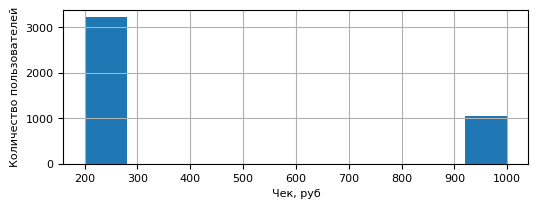

In [45]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot()
ab_data.loc[ab_data.grp == 'A', 'price'].dropna().hist()
ax.set_xlabel('Чек, руб', fontsize=8)
ax.set_ylabel('Количество пользователей', fontsize=8)
ax.tick_params(labelsize=8)
plt.show()

Так как распределения признаков не бинарные (0-1) и не нормальные, нужно использовать для сравнения средних непараметрический U-тест Манна-Уитни.

<b>Постановка гипотезы</b>
- H0: разница среднего чека в группе А и В отсутствует
- H1: средний чек в группе A > средний чек в группе B т.е средний чек в В упал 

<b>Наблюдения</b>
- выборочное среднее чека в группе А = 396.12
- выборочное среднее чека в группе В = 348.8
- Нет оснований полагать, что истинные стандартные отклонения чека в A и B равны. 

В качестве уровня значимости альфа возьмем 0,05. 

In [56]:
bills_A = ab_data.loc[ab_data.grp == 'A', 'price'].dropna(axis=0)
bills_B = ab_data.loc[ab_data.grp == 'B', 'price'].dropna(axis=0)

u_bill = stats.mannwhitneyu(bills_A, bills_B, alternative='greater')  # greater - a>b
print('U-статистика:', u_bill[0], '\t', 'p-value:', u_bill[1])

U-статистика: 28984683.0 	 p-value: 0.0


<b>Вывод о среднем чеке</b>\
p-value гораздо меньше 0.05, поэтому мы отвергаем нулевую гипотезу о равенстве средних чеков в пользу альтернативной и считаем, что средний чек в А действительно значимо больше чем в В.

#### <u>2.3) ARPU</u><a id="arpu"></a>

У нас весьма небольшое количество цен на подписки, поэтому очевидно, что средняя выручка на пользователя не будут распределена нормально. Визуализируем распределение средних чеков.

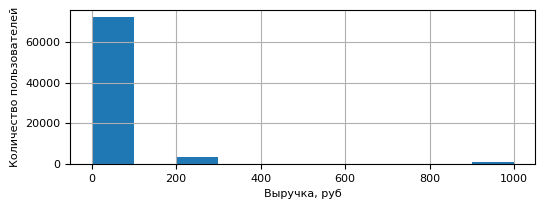

In [47]:
fig = plt.figure(figsize=(6, 2))
ax = fig.add_subplot()
ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0).hist()
ax.set_xlabel('Выручка, руб', fontsize=8)
ax.set_ylabel('Количество пользователей', fontsize=8)
ax.tick_params(labelsize=8)
plt.show()

Так как распределения признаков не бинарные (0-1) и не нормальные, нужно использовать для сравнения средних  непараметрический U-тест Манна-Уитни.

<b>Постановка гипотезы</b>
- H0: ARPU в группе А = ARPU в группе В
- H1: ARPU в группе A < ARPU в группе B т.е ARPU в В выросло

<b>Наблюдения</b>
- выборочное ARPU в группе А = 22.13
- выборочное ARPU в группе В = 42.91
- Нет оснований полагать, что истинные стандартные отклонения доходов с каждого пользователя в A и B равны. 

В качестве уровня значимости альфа возьмем 0,05. 



In [57]:
ARPU_A = ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0)
ARPU_B = ab_data.loc[ab_data.grp == 'B', 'price'].fillna(0)

u_arpu = stats.mannwhitneyu(ARPU_A, ARPU_B, alternative='less')  # less - a<b

print('U-статистика:', u_arpu[0], '\t', 'p-value:', u_arpu[1].round(5))

U-статистика: 2746687083.0 	 p-value: 0.0


<b>Вывод об ARPU</b>\
Очень маленькое p-value, гораздо меньшее чем 0.05, поэтому мы отвергаем нулевую гипотезу о равенстве ARPU в А и В и считаем, что ARPU в B действительно значимо больше чем в A.

#### <u>3) Доверительные интервалы</u><a id="ci"></a>

Интервал в котором «скорее всего» лежит истинное значение.\
(Например: с 95%-ной вероятностью в нашем интервале лежит реальное значение, и лишь в 5 % случаев мы ошибаемся).

Показывает, насколько параметры из выборочной совокупности могут отличаться от реально существующих данных в генеральной совокупности. Насколько мы ошибаемся при формировании той или иной выборки, мы закладываем в так называемую ошибку репрезентативности, в ошибку средней и вокруг нее собственно и строим доверительный интервал.

Уровень значимости связан с доверительным интервалом и отражает степень нашей уверенности, что истинное значение находится внутри данного доверительного интервала. Чем меньше уровень значимости, тем мы более уверены.

Посчитаем 95% доверительные интервалы для конверсии, ARPU и среднего чека. 

In [55]:
#Функции для получения доверительных интервалов

# Считает доверительные интервалы для средних
def get_conf_interval(data, conf_level = 0.95):  
        buf = (stats.t.interval(conf_level, len(data),
                                loc=np.mean(data), scale=stats.sem(data)))        
        return float((buf[1] - buf[0])/2)  # возвращаем предел погрешности
    
#Считает доверительные интервалы для бинарных величин
def get_conf_interval_z(succ, tot):  
    buf = proportion_confint(succ, tot)
    return buf[1] - buf[0]  # возвращаем предел погрешности

In [51]:
#Доверительные интервалы
conf_conv_A = get_conf_interval_z(ab_data.loc[ab_data.grp == 'A', 'price'].dropna(axis=0).count(), 
                                            ab_data.loc[ab_data.grp == 'A', 'user_id'].count())
conf_conv_B = get_conf_interval_z(ab_data.loc[ab_data.grp == 'B', 'price'].dropna(axis=0).count(), 
                                            ab_data.loc[ab_data.grp == 'B', 'user_id'].count())

conf_bill_A = get_conf_interval(ab_data.loc[ab_data.grp == 'A', 'price'].dropna(axis=0))
conf_bill_B = get_conf_interval(ab_data.loc[ab_data.grp == 'B', 'price'].dropna(axis=0))

conf_ARPU_A = get_conf_interval(ab_data.loc[ab_data.grp == 'A', 'price'].fillna(0))
conf_ARPU_B = get_conf_interval(ab_data.loc[ab_data.grp == 'B', 'price'].fillna(0))

print('Доверительные интервалы:')
print('Конверсия группы A:', f'± {conf_conv_A:.3f}')
print('Конверсия группы A:', f'± {conf_conv_B:.3f}')                             
print('Средний чек группы A:', f'± {conf_bill_A:.2f}')
print('Средний чек группы A:', f'± {conf_bill_B:.2f}')
print('ARPU группы A:', f'± {conf_ARPU_A:.2f}')
print('ARPU группы B:', f'± {conf_ARPU_B:.2f}')

Доверительные интервалы:
Конверсия группы A: ± 0.003
Конверсия группы A: ± 0.005
Средний чек группы A: ± 10.32
Средний чек группы A: ± 5.47
ARPU группы A: ± 0.86
ARPU группы B: ± 1.05


#### <u>4) Отчёт</u><a id="sum"></a>

[Text(0, 0, '0'), Text(0, 0, '1,592,693')]

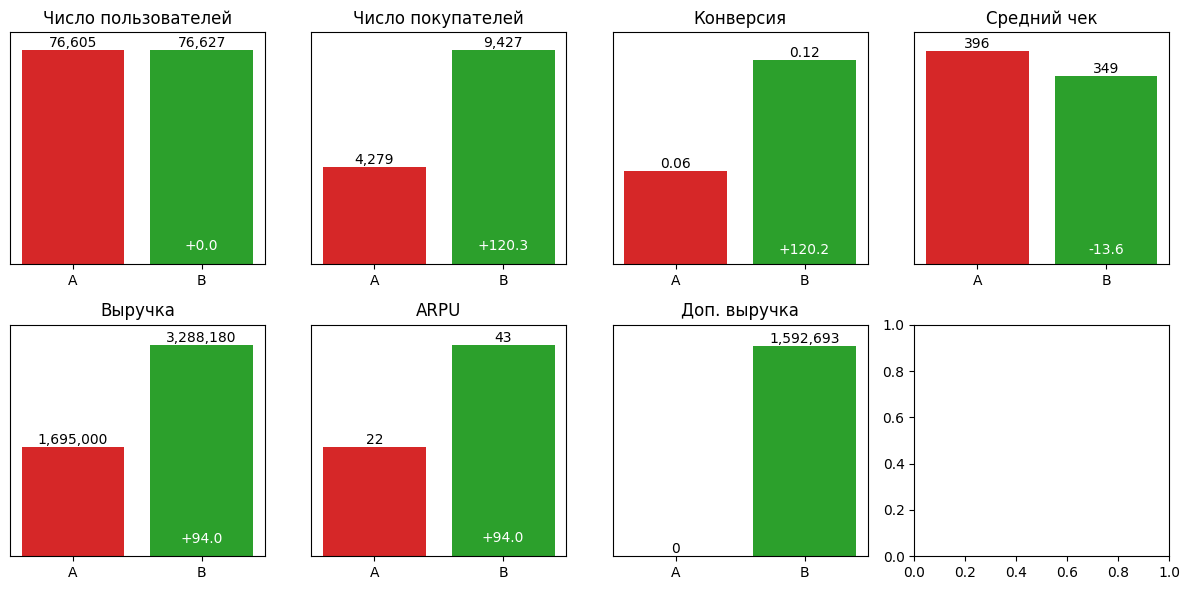

In [52]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6), tight_layout=True)

bar_container = ax[0, 0].bar(['A', 'B'], [ab_summary.users_count.A, ab_summary.users_count.B], color=['tab:red', 'tab:green'])
ax[0, 0].set(title='Число пользователей', yticks=([]), ylim=[0, 83000])
ax[0, 0].bar_label(bar_container, fmt='{:,.0f}')
ax[0, 0].text(1, 5000, s=f'{ab_summary['UC, %']['B']}', color='white', horizontalalignment='center')

bar_container = ax[0, 1].bar(['A', 'B'], [ab_summary.buyers_count.A, ab_summary.buyers_count.B], color=['tab:red', 'tab:green'])
ax[0, 1].set(title='Число покупателей', yticks=([]), ylim=[0, 10200])
ax[0, 1].bar_label(bar_container, fmt='{:,.0f}')
ax[0, 1].text(1, 600, s=f'{ab_summary['BC, %']['B']}', color='white', horizontalalignment='center')

bar_container = ax[0, 2].bar(['A', 'B'], [ab_summary.conversion.A, ab_summary.conversion.B], color=['tab:red', 'tab:green'])
ax[0, 2].set(title='Конверсия', yticks=([]), ylim=[0, 0.14])
ax[0, 2].bar_label(bar_container, fmt='{:.2f}')
ax[0, 2].text(1, 0.006, s=f'{ab_summary['C, %']['B']}', color='white', horizontalalignment='center')

bar_container = ax[0, 3].bar(['A', 'B'], [ab_summary.avg_bill.A, ab_summary.avg_bill.B], color=['tab:red', 'tab:green'])
ax[0, 3].set(title='Средний чек', yticks=([]), ylim=[0, 430])
ax[0, 3].bar_label(bar_container, fmt='{:,.0f}')
ax[0, 3].text(1, 18, s=f'{ab_summary['AB, %']['B']}', color='white', horizontalalignment='center')

bar_container = ax[1, 0].bar(['A', 'B'], [ab_summary.revenue.A, ab_summary.revenue.B], color=['tab:red', 'tab:green'])
ax[1, 0].set(title='Выручка', yticks=([]), ylim=[0, 3600000])
ax[1, 0].bar_label(bar_container, fmt='{:,.0f}')
ax[1, 0].text(1, 200000, s=f'{ab_summary['R, %']['B']}', color='white', horizontalalignment='center')

bar_container = ax[1, 1].bar(['A', 'B'], [ab_summary.ARPU.A, ab_summary.ARPU.B], color=['tab:red', 'tab:green'])
ax[1, 1].set(title='ARPU', yticks=([]), ylim=[0, 47])
ax[1, 1].bar_label(bar_container, fmt='{:,.0f}')
ax[1, 1].text(1, 3, s=f'{ab_summary['A, %']['B']}', color='white', horizontalalignment='center')

bar_container = ax[1, 2].bar(['A', 'B'], [0, ab_summary.add_rev.B], color=['tab:red', 'tab:green'])
ax[1, 2].set(title='Доп. выручка', yticks=([]), ylim=[0, 1750000])
ax[1, 2].bar_label(bar_container, fmt='{:,.0f}')

#### <u>5) Выводы</u><a id="fin"></a>

1. Скидка значимо увеличила ARPU на 94%
2. Скидка уменьшила средний чек на 13,6%
3. Скидка значимо увеличила конверсию на 120%
4. Дополнительная выручка составила 1,59 млн.руб.\
\
<b>Таким образом, скидки способствуют увеличению выручки, поэтому их можно проводить время от времени.</b>